### DATA COLLECTION

In [ ]:
# Necessary Imports
from flask import Flask, jsonify
from werkzeug.routing import IntegerConverter
from _csv import Dialect as _Dialect
import copy
import csv
import os
from lib.rtls_slave import pixel_calculate, aoa_main, sort_data
import json


ENVIRONMENT = 'random'

# Handle Negative Values
class SignedIntConverter(IntegerConverter):
    regex = r'-?\d+'
app = Flask(__name__)
app.url_map.converters['signed_int'] = SignedIntConverter
#Store input values: AoA and Horizontal Angle

aoabefore = {}
aoa= {}
lev = []

@app.route('/')
def home():
    return "This is the HomePage"

#Routing Settings
@app.route('/send/<signed_int:horiz>', methods=['GET'])
def get_angle(horiz):
    global aoa
    global aoabefore
    
    print("Plane Angle: " + str(horiz))
    aoa_result = aoa_main()
    print(aoa_result)
    input_letter = input("If you want to add this data to list type 'y', otherwise press Enter")
    if input_letter!='y':
        return jsonify({'state':'Try Again'})
    lev.append(horiz)
    aoabefore = copy.deepcopy(aoa)
    aoa = aoa_result

    with open(f"./data/aoa_data/{ENVIRONMENT}_{horiz}.json",'w') as f:
        json.dump(aoa_result, f)
        
    return jsonify({'state': 'success'})

@app.route('/calculate/', methods=['GET'])
def calculate():
    # ANGLE SORTING TECHNIQUES
    aoabefore_ = sort_data(aoabefore,aoa_bias = -35)
    aoa_ = sort_data(aoa,aoa_bias = -35)

    print("Before Turning："+str(aoabefore)+'\n'+"After Turning： " + str(aoa) +'\n'+"Rotation Angle： "+ str(lev))
    set_aoa = set(aoa_)
    set_aoabefore = set(aoabefore_)

    for slave in set_aoa.intersection(set_aoabefore):
        f = open(f"./results/pixels/{slave.replace(':','_')}.csv",'w',newline="")
        f.truncate()
        writer = csv.writer(f)
        
        data_before = aoabefore_[slave]
        data_after = aoa_[slave]

        for i in range(len(data_before[0])):
            for j in range(len(data_after[0])):
                (temp1, temp2) = pixel_calculate(lev[-2] - lev[-1], data_before[0][i], data_after[0][j])
                count = data_before[1][i]*data_after[1][j]
                if temp1 != 1:
                    tux = (temp1, temp2,count)
                    writer.writerow(tux)

        f.close()
                
        
        f.close()

    
    return jsonify({'state': 'success'})

In [ ]:
ENVIRONMENT = 'two_top_outtest'
app.run(host='0.0.0.0',port = 5000, debug=False)
# My Charger: 80:6F:B0:EE:AD:32 : Water Bottle.
# Ishrath Charger:  80:6F:B0:EE:AA:13 : Tea Bottle.

### POST POINT CALCULATION

In [6]:
from lib.rtls_slave import post_calculation

# POST-ANALYSIS
post_calculation('two_top_indoor',64,73,aoa_bias=-36)

Rotation Angle: 64 --> 73
Slave :80:6F:B0:EE:AA:13 
 AoA Before:[-12.56125 -12.14125 -11.72125 -11.30125 -10.88125 -10.46125] 
 AoA After:[-12.7        -12.23333333 -11.76666667 -11.3       ] 

Slave :80:6F:B0:EE:9C:67 
 AoA Before:[10.71103448 11.07503448 11.43903448 11.80303448 12.16703448 12.53103448
 12.89503448 13.25903448] 
 AoA After:[6.69444444 7.05740741 7.42037037 7.78333333 8.1462963  8.50925926
 8.87222222 9.23518519] 



### VISUALIZING THE ANGLE

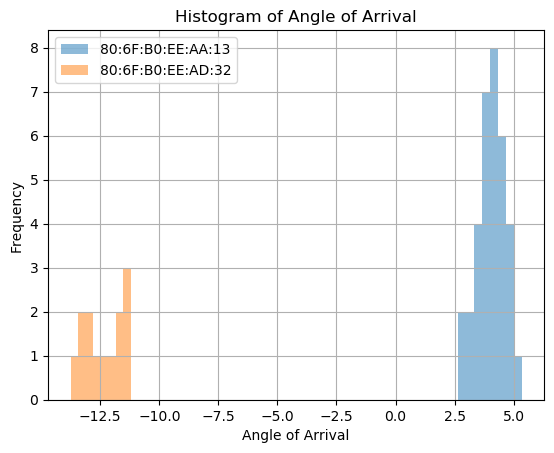

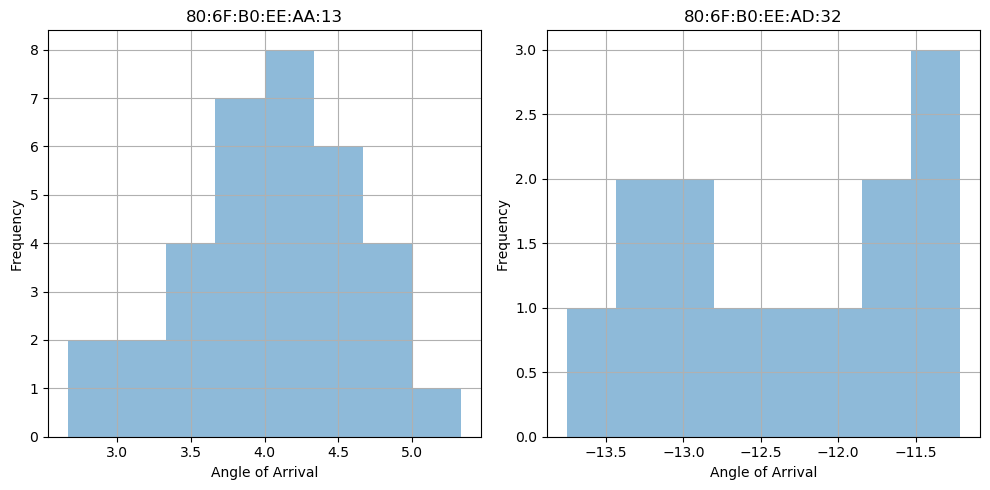

'SUCCESS'

In [1]:
from lib.rtls_slave import visualize_aoa_spread

CASE = 'two_down_outdoor'
level = 85
visualize_aoa_spread(CASE, level)

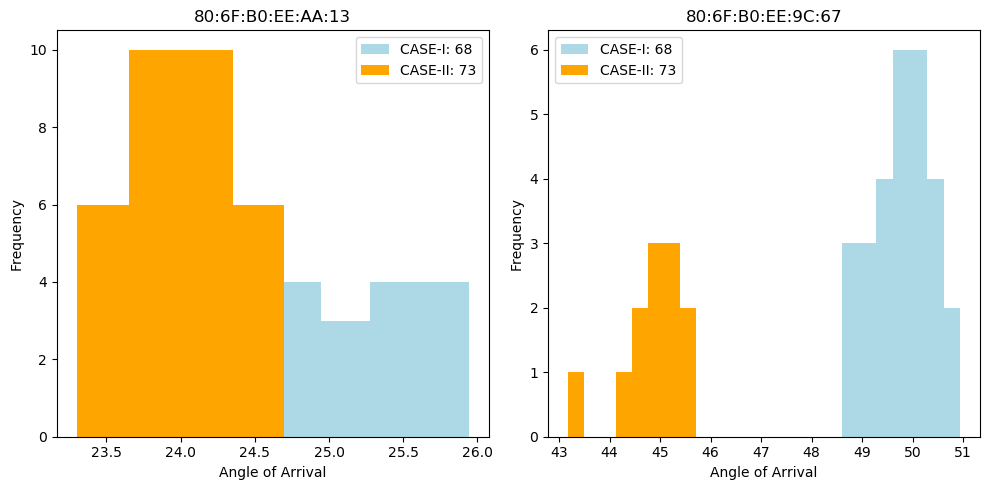

In [3]:
from lib.rtls_slave import visualize_aoa_turn_spread

CASE = 'two_top_indoor'
level1 = 68
level2 = 73
vis_bias = 0

visualize_aoa_turn_spread(CASE, level1, level2, vis_bias)